# Let's demo a few of the things we can can do with astropy!

# 1 - Reading and Analyzing Fits Images

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [43]:
# Import the astropy fits library
from astropy.io import fits

In [140]:
# Load a FITS file. The FITS format can be used to contain images, data cubes and tables. 
# When you use the fits.open() function, astropy returns a list of Header Data Units - usually there is just
# one, so we just select the first one.
fits_file = fits.open('HorseHead.fits')[0]

In [142]:
#All FITS images have a header with useful information about the observation -Let's look at the header info 
fits_file.header

SIMPLE  =                    T /FITS: Compliance                                
BITPIX  =                   16 /FITS: I*2 Data                                  
NAXIS   =                    2 /FITS: 2-D Image Data                            
NAXIS1  =                  891 /FITS: X Dimension                               
NAXIS2  =                  893 /FITS: Y Dimension                               
EXTEND  =                    T /FITS: File can contain extensions               
DATE    = '2014-01-09        '  /FITS: Creation Date                            
ORIGIN  = 'STScI/MAST'         /GSSS: STScI Digitized Sky Survey                
SURVEY  = 'SERC-ER '           /GSSS: Sky Survey                                
REGION  = 'ER768   '           /GSSS: Region Name                               
PLATEID = 'A0JP    '           /GSSS: Plate ID                                  
SCANNUM = '01      '           /GSSS: Scan Number                               
DSCNDNUM= '00      '        

In [46]:
# Want a specific FITS header value? Here's how to get it.
fits.getval('HorseHead.fits', 'DATE')

'2014-01-09'

In [143]:
# We can load the data as a numpy array and get some basic statistics like so:
print(fits_file.data.shape)
data = fits_file.data
print(np.std(data))
print(np.median(data))
print(np.max(data))

(893, 891)
3032.3927542049046
9658.0
22918


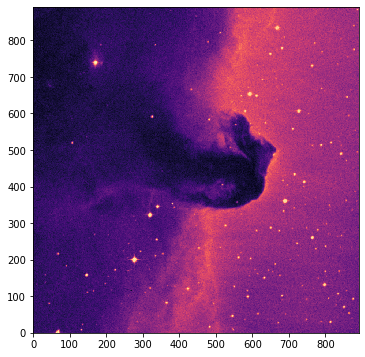

In [145]:
# Plot the image with matplotlib - always use orgin='lower' for the correct orientation of FITS images.
plt.figure(figsize=(6,6))
plt.imshow(fits_file.data, origin='lower', cmap='magma')

# 2 - The astropy table object

Data tables in astronomy don't correspond well to any built in python data structures. We can use the astropy table object to handle various complexities of our data such as missing values.

In [165]:
from astropy.table import Table, join

In [175]:
# Read data from a .csv file - astropy can also read data in FITS table, HDF5, and other formats.
# Here I have told astropy to mask entries with a blank character, '-' or '?'.
t = Table.read('example_table.csv', format='ascii',
               fill_values=[('', 0.), ('-', 0.), ('?', 0.)]) 

In [176]:
# Get an interactive table interface to search and sort!
t.show_in_notebook()

idx,name,mass,radius,note
0,tiny dog planet,0.1,1.1,good boys here
1,space planet,--,--,detected by Author et al.
2,Arrakis,1.2,1.1,--
3,Ballderan,1.1,30.0,--
4,backup earth,1.0,1.0,--


In [177]:
# This works too if you are not using juypter, opens table in a new tab:
t.show_in_browser(jsviewer=True)

In [154]:
# Sort the table by the 'mass' column
t.sort('mass')
t.show_in_notebook()

idx,name,mass,radius,note
0,tiny dog planet,0.1,1.1,good boys here
1,backup earth,1.0,1.0,--
2,Ballderan,1.1,30.0,--
3,Arrakis,1.2,1.1,--
4,space planet,--,--,detected by Author et al.


In [178]:
# Let's create a second table from scratch with some other information.
# There are many ways to do this, in general you can construct tables from rows or columns,
# and add/delete rows columns as needed: https://docs.astropy.org/en/stable/table/construct_table.html

planet_names = ['tiny dog planet', 'space planet', 'Arrakis', 'backup earth', 'seagull planet', 'mercury', 'earth classic', 'Ballderan']
spice = [False, False, True, False, False, True, False, True]
dogs = [True, False, False, False, True, False, False, True]
t2 = Table([planet_names, spice, dogs], names=['name', 'spice?', 'dogs?'])
t2.show_in_notebook()

idx,name,spice?,dogs?
0,tiny dog planet,False,True
1,space planet,False,False
2,Arrakis,True,False
3,backup earth,False,False
4,seagull planet,False,True
5,mercury,True,False
6,earth classic,False,False
7,Ballderan,True,True


In [180]:
# Astropy tables can let you do database style matching - here we join the two tables using the shared 'name' column
t3 = Table(join(t, t2, keys='name'))
t3.show_in_notebook()

idx,name,mass,radius,note,spice?,dogs?
0,Arrakis,1.2,1.1,--,True,False
1,Ballderan,1.1,30.0,--,True,True
2,backup earth,1.0,1.0,--,False,False
3,space planet,--,--,detected by Author et al.,False,False
4,tiny dog planet,0.1,1.1,good boys here,False,True


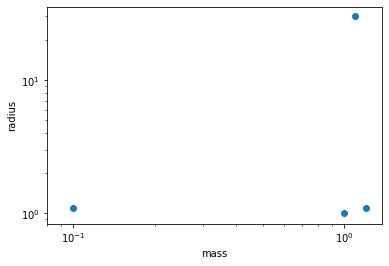

In [182]:
# Let's make a simple plot from our table
plt.scatter(t3['mass'], t3['radius'])
plt.xlabel('mass')
plt.ylabel('radius')
plt.xscale('log')
plt.yscale('log')


In [183]:
# Print only some rows of the table:
t3[0:2]

name,mass,radius,note,spice?,dogs?
str15,float64,float64,str25,bool,bool
Arrakis,1.2,1.1,--,True,False
Ballderan,1.1,30.0,--,True,True


In [187]:
# Want to look up data using unique identifiers in certain columns? Just add the column as n
t3.add_index('name')
t3.loc[['Arrakis', 'tiny dog planet']]

name,mass,radius,note,spice?,dogs?
str15,float64,float64,str25,bool,bool
Arrakis,1.2,1.1,--,True,False
tiny dog planet,0.1,1.1,good boys here,False,True


In [189]:
# Let's write our joined table out in latex - we'll first fill missing values with something. 
t3_filled = t3.filled()
t3_filled

name,mass,radius,note,spice?,dogs?
str15,float64,float64,str25,bool,bool
Arrakis,1.2,1.1,N/A,True,False
Ballderan,1.1,30.0,N/A,True,True
backup earth,1.0,1.0,N/A,False,False
space planet,1e+20,1e+20,detected by Author et al.,False,False
tiny dog planet,0.1,1.1,good boys here,False,True


In [190]:
t3_filled.write('publish_me.tex', format='ascii.latex', overwrite=True)

This creates a file 'publish_me.tex' with valid latex you can compile!
```
\begin{table}
\begin{tabular}{cccccc}
name & mass & radius & note & spice? & dogs? \\
Arrakis & 1.2 & 1.1 & N/A & True & False \\
Ballderan & 1.1 & 30.0 & N/A & True & True \\
backup earth & 1.0 & 1.0 & N/A & False & False \\
space planet & 1e+20 & 1e+20 & detected by Author et al. & False & False \\
tiny dog planet & 0.1 & 1.1 & good boys here & False & True \\
\end{tabular}
\end{table}


```

# 3 - Astropy Skycoord Object

Coordinates in astronomy are complicated due to the variety of reference frames, equinoxes, and even ways of writing Ra and Dec. Using the astropy SkyCoord object can greatly simplify coordinate operations. Coordinates can include Ra, Dec, proper motion, and distance, and there are builtin functions for calculating distances/motions, changing reference frame, and matching.

In [77]:
from astropy.coordinates import SkyCoord

In [200]:
# Create a coordinate from a string
c = SkyCoord("1h12m43.2s +31d12m43s", frame='icrs')
# Create a coordinate from as string written slightly differently
c2 =SkyCoord("1:12:43.2 +1:12:43", unit=(u.deg, u.hourangle), frame='icrs')

In [201]:
# Print out some basic information in a variety of ways:
print(c.ra)
print(c.dec)
print(c.ra.deg)
print(c.dec.deg)
print(c.ra.deg*np.cos(np.deg2rad(c.dec.deg))) # correct for cos dec

18d10m48s
31d12m43s
18.179999999999996
31.211944444444445
15.5485585985369


In [91]:
# calculate a (on-sky) separation
c.separation(c2)

<Angle 0.21647722 deg>

In [94]:
# What's out first coord in a Galactic frame?
c.galactic

<SkyCoord (Galactic): (l, b) in deg
    (128.26535036, -31.43931303)>

In [96]:
# How about fk5?
c.fk5

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (18.18001002, 31.21194512)>

In [203]:
# Which constellation is this in?
c.get_constellation()

'Pisces'

# 4 - Astropy quantity objects and constants

Astropy can make dealing with units in your code easier using Quantity object. A Quantity is essentially a numpy array with an associated physical unit. We can standard also import standard (astro)physical constants from astropy to avoid having to enter this over and over in our work.

In [99]:
import astropy.units as u
from astropy.constants import au

In [98]:
# How many meters in an au again?
au

<<class 'astropy.constants.iau2015.IAU2015'> name='Astronomical Unit' value=149597870700.0 uncertainty=0.0 unit='m' reference='IAU 2012 Resolution B2'>

In [204]:
# What's that in pc?
au.to(u.pc)

<Quantity 4.84813681e-06 pc>

In [104]:
# in km?
au.to(u.km)

<Quantity 1.49597871e+08 km>

In [214]:
# All constants can be converted to cgs or SI as needed:
au.cgs

<Quantity 1.49597871e+13 cm>

In [213]:
au.si

<<class 'astropy.constants.iau2015.IAU2015'> name='Astronomical Unit' value=149597870700.0 uncertainty=0.0 unit='m' reference='IAU 2012 Resolution B2'>

In [215]:
# astropy quantity and constants are great when combined to do simple back of the terminal calculations!
# Let's calculate how far the earth moves in a day
speed =au*2.0*np.pi/(365.25*u.day)

In [216]:
speed

<Quantity 2.57344598e+09 m / d>

In [217]:
# let's convert to more familiar units:
speed.to(u.km/u.s)

<Quantity 29.78525437 km / s>

# 5 Extragalactic bonus - dealing with different cosmologies

Want to get redshift, luminosity distance, and other quantities that depend on whether our universe is a pancake or a donut? Astropy allows you to import cosmological parameters (or define your own) to make working with redshift easier.

In [218]:
from astropy.cosmology import WMAP9, Planck15

In [219]:
z=[2,5]

In [220]:
WMAP9.H0

<Quantity 69.32 km / (Mpc s)>

In [221]:
Planck15.H0

<Quantity 67.74 km / (Mpc s)>

In [139]:
WMAP9.age([2,5])

<Quantity [3.32678486, 1.19002439] Gyr>